# Identifying Fraud from Enron Email

by Gaurav Ansal

## Project Overview

In 2000, Enron was one of the largest companies in the United States. By 2002, it had collapsed into bankruptcy due to widespread corporate fraud. In the resulting Federal investigation, a significant amount of typically confidential information entered into the public record, including tens of thousands of emails and detailed financial data for top executives. In this project, we will put machine learning skills to use by building a person of interest identifier based on financial and email data made public as a result of the Enron scandal. 

In this project, we would make an attempts to predict the likelihood of someone being a suspect of Enron fraud conspiracy by looking at given dataset. We call these suspects - Person of Interest (POI). The dataset contains financial information of all Enron executives as well as emails sent/received through their company email accounts, and their POI status.

POI status means individuals who were indicted, reached a settlement or plea deal with the government, or testified in exchange for prosecution immunity.

We would use machine learning to learn insider pays and emailing habits of POIs and non-POIs and see if we can find a pattern there, then use the algorithm/model built to predict the likeliness of someone being a POI or not.
Machine learning brings together computer science and statistics to harness that predictive power.

## Data Exploration

In [378]:
#!/usr/bin/python

import sys
import pickle
import pprint
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import operator
from copy import deepcopy
import matplotlib.patches as mpatches
import matplotlib.patches
%pylab inline
sys.path.append("../tools/")

from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data, test_classifier

Populating the interactive namespace from numpy and matplotlib


### Loading the dictionary containing the dataset

We have the enron dataset in the form of pickle file which is "final_project_dataset.pkl"

In [379]:
## Loading the dictionary containing the dataset

with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)
   

###### Below is the list of features of each person -  

In [380]:
## List of features of each person

pprint.pprint(data_dict[data_dict.keys()[0]].keys())
print '\n'
print "Number of features:", len(data_dict[data_dict.keys()[0]].keys())

['salary',
 'to_messages',
 'deferral_payments',
 'total_payments',
 'exercised_stock_options',
 'bonus',
 'restricted_stock',
 'shared_receipt_with_poi',
 'restricted_stock_deferred',
 'total_stock_value',
 'expenses',
 'loan_advances',
 'from_messages',
 'other',
 'from_this_person_to_poi',
 'poi',
 'director_fees',
 'deferred_income',
 'long_term_incentive',
 'email_address',
 'from_poi_to_this_person']


Number of features: 21


Each key-value pair in the dictionary corresponds to one person. The dictionary key is the person's name, and the value is another dictionary, which contains the names of all the features and their values for that person. The features in the data fall into three major types, namely financial features, email features and POI labels.

financial features: ['salary', 'deferral_payments', 'total_payments', 'loan_advances', 'bonus', 'restricted_stock_deferred', 'deferred_income', 'total_stock_value', 'expenses', 'exercised_stock_options', 'other', 'long_term_incentive', 'restricted_stock', 'director_fees'] (all units are in US dollars)

email features: ['to_messages', 'email_address', 'from_poi_to_this_person', 'from_messages', 'from_this_person_to_poi', 'shared_receipt_with_poi'] (units are generally number of emails messages; notable exception is ‘email_address’, which is a text string)

POI label: [‘poi’] (boolean, represented as integer)

###### Total number of data points

In [381]:
## Total number of data points

print len(data_dict)

146


###### Allocation across classes (POI/non-POI)

In [382]:
## Allocation across classes (POI/non-POI)

i = 0
j = 0
for key in data_dict.keys():
    if data_dict[key]['poi'] == True:
        i = i + 1
    elif data_dict[key]['poi'] == False:
        j = j + 1
print  "Number of data points with POI class:", i
print  "Number of data points with non-POI class:", j
        
    

Number of data points with POI class: 18
Number of data points with non-POI class: 128


There are very less POI data points as compared to non-POI data points.

###### Features with many missing values

In [383]:
## Features with many missing values

features_nan = {}
for key in data_dict.keys():
    for feature in data_dict[key].keys():
        if data_dict[key][feature] == 'NaN':
            if feature not in features_nan:
                features_nan[feature] = int(1)
            else:
                features_nan[feature] = features_nan[feature] + 1
print "Features with count of NaN's:\n"
pprint.pprint(features_nan)
            
        
        

Features with count of NaN's:

{'bonus': 64,
 'deferral_payments': 107,
 'deferred_income': 97,
 'director_fees': 129,
 'email_address': 35,
 'exercised_stock_options': 44,
 'expenses': 51,
 'from_messages': 60,
 'from_poi_to_this_person': 60,
 'from_this_person_to_poi': 60,
 'loan_advances': 142,
 'long_term_incentive': 80,
 'other': 53,
 'restricted_stock': 36,
 'restricted_stock_deferred': 128,
 'salary': 51,
 'shared_receipt_with_poi': 60,
 'to_messages': 60,
 'total_payments': 21,
 'total_stock_value': 20}


From the above summary, below features have many NaN values. 

director_fees,
loan_advances,
deferral_payments,
deferred_income,
restricted_stock_deferred

These are not actual missing values but should be replaced by value 0 as could be understood from Payments to Insiders report by FindLaw - 'enron61702insiderpay.pdf'

In [384]:
### Task 1: Select what features you'll use.
### features_list is a list of strings, each of which is a feature name.
### The first feature must be "poi".
features_list = ['poi',
                 'salary',
                 'to_messages',
                 'deferral_payments',
                 'total_payments',
                 'exercised_stock_options',
                 'bonus',
                 'restricted_stock',
                 'shared_receipt_with_poi',
                 'restricted_stock_deferred',
                 'total_stock_value',
                 'expenses',
                 'loan_advances',
                 'from_messages',
                 'other',
                 'from_this_person_to_poi',
                 'director_fees',
                 'deferred_income',
                 'long_term_incentive',
                 'from_poi_to_this_person'] 

## Dealing with Outliers in the dataset

### Finding outliers by visualizing the data

One way to find outliers is by visualizing the data, then use our human intuition to find suspicious looking values. Here are the histograms of all features except email_address:

In [385]:
### Task 2: Remove outliers

In [386]:
## Extracting selected features from data_dict

features = features_list
data = featureFormat(data_dict, features)

###### Histograms of all features except email_address

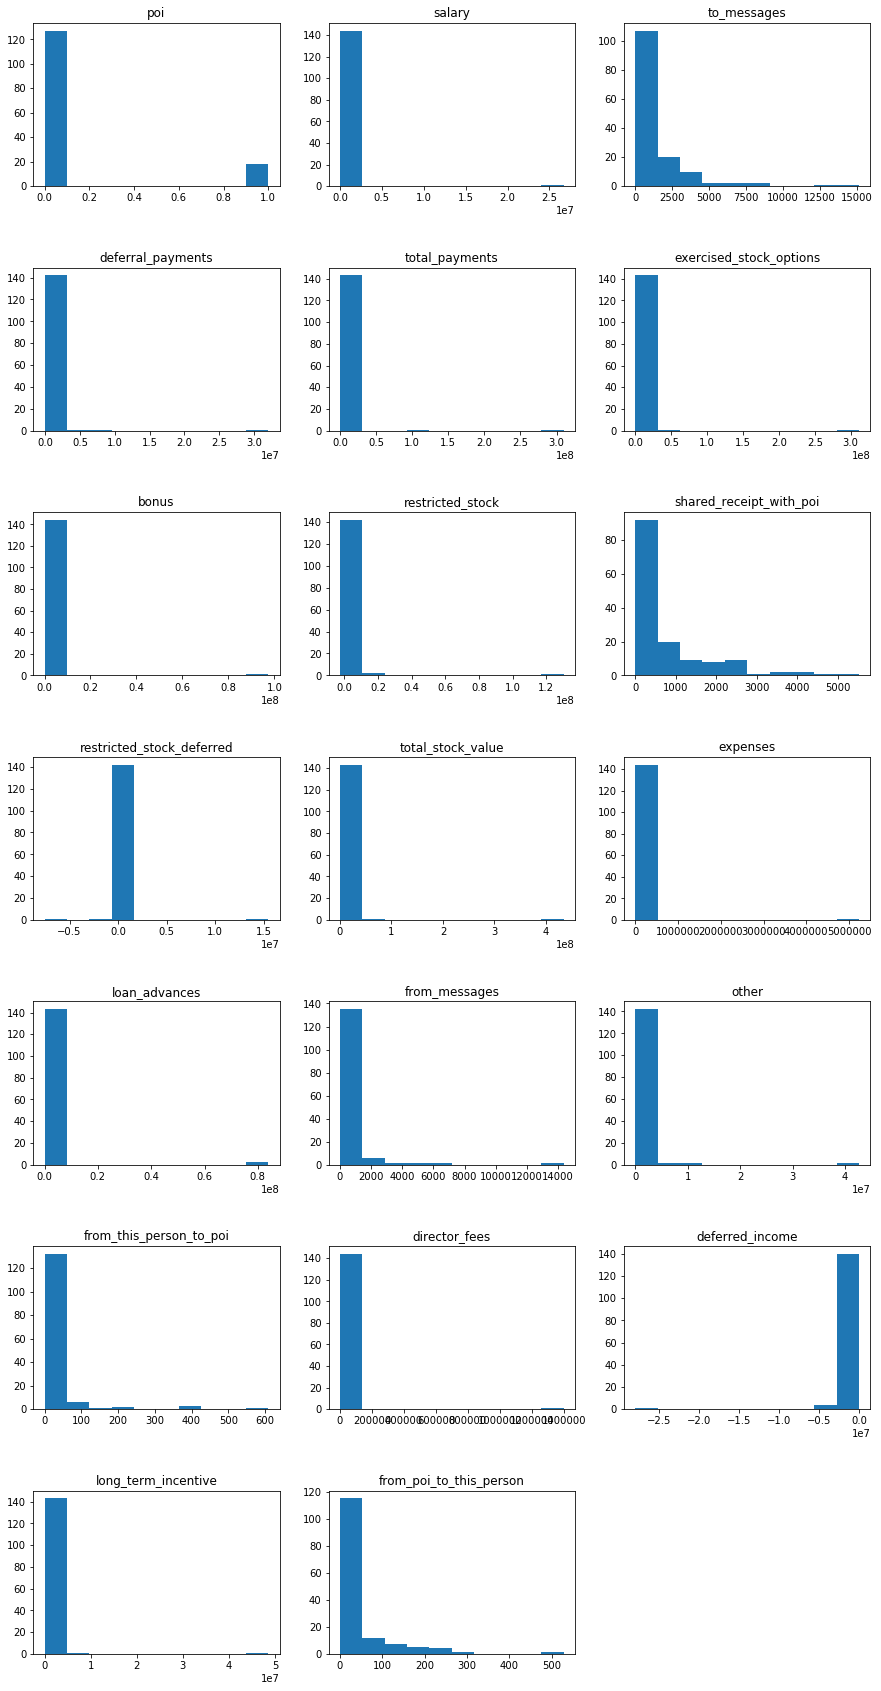

In [387]:
## Histograms of features

fig = plt.figure(figsize=(15, 30))

for i,feature in enumerate(features):
    ax = plt.subplot(7,3,i+1)
    ax.hist(data[:,i])
    ax.set_title(feature)
    plt.subplots_adjust(hspace=.5)
    

From the above histograms and judging by the x-axis scales of some of our histograms like bonus, salary, etc., there seems to be some outliers in our dataset. But are these outliers part of POI or are they part of non-POI data points? Because if they are part of POI data points, then certainly there is a pattern within POI features.

###### Top 5 largest values of the features which might have outliers as per above histograms 

Lets have a sneak peek of top 5 largest values of the features which might have outliers as per above histograms and check i) if they have POI or non-POI status and ii) to whom they belong to.

In [388]:
## Defining a function to have largest 5 values of the features which might have outliers and
## checking if the data point has POI or non-POI status, 
## and to whom the data point belongs

data_dict_test1  = data_dict
features_test = ['salary', 
                 'deferral_payments', 
                 'exercised_stock_options', 
                 'bonus', 
                 'restricted_stock', 
                 'restricted_stock_deferred',
                 'expenses', 
                 'loan_advances', 
                 'other', 
                 'director_fees', 
                 'long_term_incentive']

#print len(data_dict_test1)

def top_5_largest_values(data,features):
    for feature in features:
        feature_values = []
        for key in data.keys():
            if data[key][feature] == 'NaN' and data[key]['poi'] == True:
                feature_values.append((key,0,'POI'))
            elif data[key][feature] == 'NaN' and data[key]['poi'] == False:
                feature_values.append((key,0,'non-POI'))
            elif data[key][feature] != 'NaN' and data[key]['poi'] == True:
                feature_values.append((key,data[key][feature], 'POI'))
            elif data[key][feature] != 'NaN' and data[key]['poi'] == False:
                feature_values.append((key,data[key][feature], 'non-POI'))
        sorted_feature_values = sorted(feature_values, key = operator.itemgetter(1),reverse = True)
        print "Largest 5 values of", feature
        print sorted_feature_values[0:5]
        print "\n"
        

In [389]:
top_5_largest_values(data_dict_test1, features_test)

Largest 5 values of salary
[('TOTAL', 26704229, 'non-POI'), ('SKILLING JEFFREY K', 1111258, 'POI'), ('LAY KENNETH L', 1072321, 'POI'), ('FREVERT MARK A', 1060932, 'non-POI'), ('PICKERING MARK R', 655037, 'non-POI')]


Largest 5 values of deferral_payments
[('TOTAL', 32083396, 'non-POI'), ('FREVERT MARK A', 6426990, 'non-POI'), ('HORTON STANLEY C', 3131860, 'non-POI'), ('HUMPHREY GENE E', 2964506, 'non-POI'), ('ALLEN PHILLIP K', 2869717, 'non-POI')]


Largest 5 values of exercised_stock_options
[('TOTAL', 311764000, 'non-POI'), ('LAY KENNETH L', 34348384, 'POI'), ('HIRKO JOSEPH', 30766064, 'POI'), ('RICE KENNETH D', 19794175, 'POI'), ('SKILLING JEFFREY K', 19250000, 'POI')]


Largest 5 values of bonus
[('TOTAL', 97343619, 'non-POI'), ('LAVORATO JOHN J', 8000000, 'non-POI'), ('LAY KENNETH L', 7000000, 'POI'), ('SKILLING JEFFREY K', 5600000, 'POI'), ('BELDEN TIMOTHY N', 5249999, 'POI')]


Largest 5 values of restricted_stock
[('TOTAL', 130322299, 'non-POI'), ('LAY KENNETH L', 14761694, 'P

From the above, we can see that largest value of most of the features(i.e. 'salary', 'deferral_payments', 'exercised_stock_options', 'bonus', 'restricted_stock', 'restricted_stock_deferred', 'expenses', 'loan_advances', 'other', 'director_fees', 'long_term_incentive') belongs to TOTAL which has a non-POI status.

Clearly, we can see that TOTAL is not any person but infact is the total of all the values of a specific feature. This must be a data entry quirk. TOTAL is clearly an outlier, and it makes sense that it caused many feature values skewed far to the right. In this case this data point needs to be removed from our dataset.  

###### Removing TOTAL from the data_dict

In [390]:
## Removing TOTAL from the data_dict

print "lenth of data_dict:", len(data_dict)
data_dict.pop('TOTAL')
print "\nlenth of data_dict after removing TOTAL:", len(data_dict)


lenth of data_dict: 146

lenth of data_dict after removing TOTAL: 145


After removing TOTAL from dataset, let us rerun the function top_5_largest_values again.

In [391]:
data_dict_test2 = data_dict

top_5_largest_values(data_dict_test2, features_test)


Largest 5 values of salary
[('SKILLING JEFFREY K', 1111258, 'POI'), ('LAY KENNETH L', 1072321, 'POI'), ('FREVERT MARK A', 1060932, 'non-POI'), ('PICKERING MARK R', 655037, 'non-POI'), ('WHALLEY LAWRENCE G', 510364, 'non-POI')]


Largest 5 values of deferral_payments
[('FREVERT MARK A', 6426990, 'non-POI'), ('HORTON STANLEY C', 3131860, 'non-POI'), ('HUMPHREY GENE E', 2964506, 'non-POI'), ('ALLEN PHILLIP K', 2869717, 'non-POI'), ('HAEDICKE MARK E', 2157527, 'non-POI')]


Largest 5 values of exercised_stock_options
[('LAY KENNETH L', 34348384, 'POI'), ('HIRKO JOSEPH', 30766064, 'POI'), ('RICE KENNETH D', 19794175, 'POI'), ('SKILLING JEFFREY K', 19250000, 'POI'), ('PAI LOU L', 15364167, 'non-POI')]


Largest 5 values of bonus
[('LAVORATO JOHN J', 8000000, 'non-POI'), ('LAY KENNETH L', 7000000, 'POI'), ('SKILLING JEFFREY K', 5600000, 'POI'), ('BELDEN TIMOTHY N', 5249999, 'POI'), ('ALLEN PHILLIP K', 4175000, 'non-POI')]


Largest 5 values of restricted_stock
[('LAY KENNETH L', 14761694, 'PO

Now, the largest values of the features belongs to a person with either POI or non-POI status.

### Finding outliers by analyzing raw data

We have to alos check for the correctness of the data in the dataset. There might be data entry quirk in any of the feature's values. For this we would have to validate and compare the data in the pickle file 'final_project_dataset.pkl' to the raw data mentioned in the Payments to Insiders report pdf file 'enron61702insiderpay.pdf'.

As we know, as per the Payments to Insiders report pdf file, the financial features of an individual has been divided into 2 groups - total_payments & total_stock_value.

total_payments is sum of values of features related to Payments i.e. ('salary', 'deferral_payments', 'loan_advances', 'bonus',  'deferred_income', 'expenses', 'other', 'long_term_incentive',  'director_fees')

&

total_stock_value is sum of values of features related to Stocks Value i.e. ('exercised_stock_options', 'restricted_stock', 'restricted_stock_deferred')

So, we can confirm if the values of the features in the data_dict is correct if the total_payments equals to sum of the values of the rest of the other features related to Payments. Similarly, would be applicable for the total_stock_value and features related to Stocks Value.

###### Validating data of the features related to Payments

In [392]:
## Validating data of the features related to Payments & Stocks Value

## Defining function validate for validating data of the features related to Payments & Stocks Value
## sum_payments is the sum of all the features related to Payments
## sum_stocks_value is the sum of the features related to Stocks Value
## feature type is either 'payments' or 'stocks_value'
## features_payments_valid is the list of features related to Payments
## features_stocks_value_valid is the list of features related to Stocks Value
## data_dict_valid is the dictionary used to validate the data

features_payments_valid  = ['salary', 
                            'deferral_payments', 
                            'loan_advances', 
                            'bonus', 
                            'deferred_income', 
                            'expenses', 
                            'other', 
                            'long_term_incentive', 
                            'director_fees']

features_stocks_value_valid = ['exercised_stock_options',
                               'restricted_stock',
                               'restricted_stock_deferred'] 

def validate(data,features,feature_type):
    for key in data.keys():
        combined_feature = []
        for feature in features:
            if data[key][feature] == 'NaN':
                combined_feature.append(float(0))
            else:
                combined_feature.append(float(data[key][feature]))    
        if feature_type == 'payments':
            data[key]['sum_payments'] = np.sum(combined_feature)
        elif feature_type == 'stocks_value':
            data[key]['sum_stocks_value'] = np.sum(combined_feature)
    for key in data.keys():
        if feature_type == 'payments':
            if data[key]['total_payments'] == 'NaN':
                data[key]['total_payments'] = float(0)
            if data[key]['sum_payments'] != data[key]['total_payments']:
                print "\n", key, "has issues with sum_payments and total_payments feature. Please check raw data and correct"
                print "sum_payments:", data[key]['sum_payments']
                print "total_payments:", data[key]['total_payments']
                print "\nBelow are the features of:", key
                for feature in features:
                    print feature, ":", data[key][feature]
                print "total_payments :", data[key]['total_payments']
        elif feature_type == 'stocks_value':
            if data[key]['total_stock_value'] == 'NaN':
                data[key]['total_stock_value'] = float(0)
            if data[key]['sum_stocks_value'] != data[key]['total_stock_value']:
                print "\n", key, "has issues with sum_stocks_value and total_stock_value feature. Please check raw data and correct"
                print "sum_stocks_value:", data[key]['sum_stocks_value']
                print "total_stock_value:", data[key]['total_stock_value']
                print "\nBelow are the features of:", key
                for feature in features:
                    print feature, ":", data[key][feature]
                print "total_stock_value :", data[key]['total_stock_value'] 
    sum_list = []
    total_list = []
    if feature_type == 'payments':
        for key in data.keys():
            sum_list.append(data[key]['sum_payments'])
            total_list.append(data[key]['total_payments'])
        if np.sum(sum_list) == np.sum(total_list):
            print "\nAll data is fine"
        elif np.sum(sum_list) != np.sum(total_list):
            print "\nAll data is not fine"   
    elif feature_type == 'stocks_value':
        for key in data.keys():
            sum_list.append(data[key]['sum_stocks_value'])
            total_list.append(data[key]['total_stock_value'])
        if np.sum(sum_list) == np.sum(total_list):
            print "\nAll data is fine"
        elif np.sum(sum_list) != np.sum(total_list):
            print "\nAll data is not fine"     
    
    

In [393]:
## Validating data of the features related to Payments
## Using the function validate for validation 

data_dict_valid1 = deepcopy(data_dict)
validate(data_dict_valid1,features_payments_valid,'payments')


BELFER ROBERT has issues with sum_payments and total_payments feature. Please check raw data and correct
sum_payments: -99215.0
total_payments: 102500

Below are the features of: BELFER ROBERT
salary : NaN
deferral_payments : -102500
loan_advances : NaN
bonus : NaN
deferred_income : NaN
expenses : NaN
other : NaN
long_term_incentive : NaN
director_fees : 3285
total_payments : 102500

BHATNAGAR SANJAY has issues with sum_payments and total_payments feature. Please check raw data and correct
sum_payments: 275728.0
total_payments: 15456290

Below are the features of: BHATNAGAR SANJAY
salary : NaN
deferral_payments : NaN
loan_advances : NaN
bonus : NaN
deferred_income : NaN
expenses : NaN
other : 137864
long_term_incentive : NaN
director_fees : 137864
total_payments : 15456290

All data is not fine


From the above output, we see that raw data and dictionary data are different for BELFER ROBERT and BHATNAGAR SANJAY for payment features. These were potentially an outliers.

###### Validating data of the features related to Stocks Value

In [394]:
## Validating data of the features related to Stocks Value
## Using the function validate for validation 

validate(data_dict_valid1,features_stocks_value_valid,'stocks_value')



BELFER ROBERT has issues with sum_stocks_value and total_stock_value feature. Please check raw data and correct
sum_stocks_value: 47378.0
total_stock_value: -44093

Below are the features of: BELFER ROBERT
exercised_stock_options : 3285
restricted_stock : NaN
restricted_stock_deferred : 44093
total_stock_value : -44093

BHATNAGAR SANJAY has issues with sum_stocks_value and total_stock_value feature. Please check raw data and correct
sum_stocks_value: 15456290.0
total_stock_value: 0.0

Below are the features of: BHATNAGAR SANJAY
exercised_stock_options : 2604490
restricted_stock : -2604490
restricted_stock_deferred : 15456290
total_stock_value : 0.0

All data is not fine


From the above output, we see that raw data and dictionary data are also different for BELFER ROBERT and BHATNAGAR SANJAY for stocks_value features. These were potentially an outliers.

###### Correcting data of the features related to Payments & Stocks Value manually

In [395]:
## Correcting data of the features related to Payments & Stocks Value manually 
## for both the persons by using raw data from pdf file

data_dict['BELFER ROBERT']['salary'] = 'NaN'
data_dict['BELFER ROBERT']['bonus'] = 'NaN'
data_dict['BELFER ROBERT']['long_term_incentive'] = 'NaN' 
data_dict['BELFER ROBERT']['deferred_income'] = -102500
data_dict['BELFER ROBERT']['deferral_payments'] = 'NaN'
data_dict['BELFER ROBERT']['loan_advances'] = 'NaN'
data_dict['BELFER ROBERT']['other'] = 'NaN'
data_dict['BELFER ROBERT']['expenses']  = 3285
data_dict['BELFER ROBERT']['director_fees'] = 102500
data_dict['BELFER ROBERT']['total_payments'] = 3285
data_dict['BELFER ROBERT']['exercised_stock_options'] = 'NaN'
data_dict['BELFER ROBERT']['restricted_stock'] = 44093
data_dict['BELFER ROBERT']['restricted_stock_deferred'] = -44093 
data_dict['BELFER ROBERT']['total_stock_value'] = 'NaN'


data_dict['BHATNAGAR SANJAY']['salary'] = 'NaN'
data_dict['BHATNAGAR SANJAY']['bonus'] = 'NaN'
data_dict['BHATNAGAR SANJAY']['long_term_incentive'] = 'NaN'
data_dict['BHATNAGAR SANJAY']['deferred_income'] = 'NaN'
data_dict['BHATNAGAR SANJAY']['deferral_payments'] = 'NaN'
data_dict['BHATNAGAR SANJAY']['loan_advances'] ='NaN'
data_dict['BHATNAGAR SANJAY']['other'] = 'NaN'
data_dict['BHATNAGAR SANJAY']['expenses'] = 137864
data_dict['BHATNAGAR SANJAY']['director_fees'] = 'NaN'
data_dict['BHATNAGAR SANJAY']['total_payments'] = 137864
data_dict['BHATNAGAR SANJAY']['exercised_stock_options'] = 15456290 
data_dict['BHATNAGAR SANJAY']['restricted_stock'] = 2604490
data_dict['BHATNAGAR SANJAY']['restricted_stock_deferred'] = -2604490
data_dict['BHATNAGAR SANJAY']['total_stock_value'] = 15456290


data_dict_valid2 = deepcopy(data_dict)


After manually correcting the entries for BELFER ROBERT and BHATNAGAR SANJAY, lets validate the data again by using validate function.

In [396]:
## Performing validation for features related to Payments

validate(data_dict_valid2,features_payments_valid,'payments')


All data is fine


In [397]:
## Performing validation for features related to Stocks Value

validate(data_dict_valid2,features_stocks_value_valid,'stocks_value')


All data is fine


Since, no bad entries were generated upon reruning the validate function for features related to Payments & Stocks Value after manually correcting the entries for both the persons, we could say that now the raw data and data_dict have the same data.

Let us now plot the histograms of all the features again with the corrected data and removing the outliers

###### Histograms with corrected data

In [398]:
## Extracting selected features from corrected data_dict

corrected_data = featureFormat(data_dict, features)

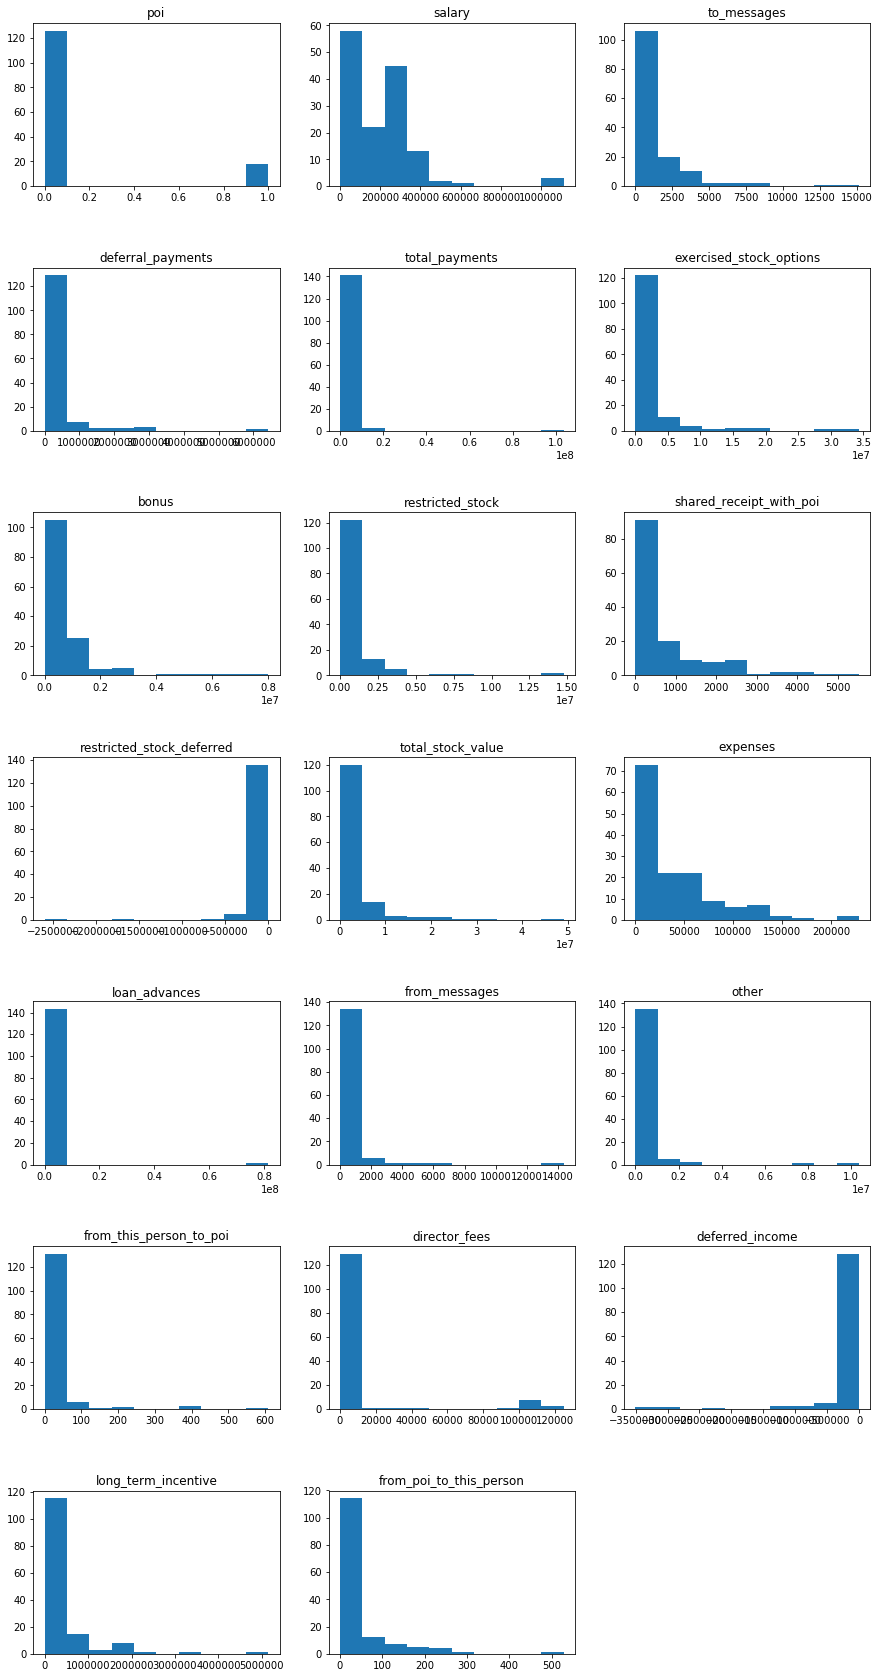

In [399]:
## Histograms of features

fig = plt.figure(figsize=(15, 30))

for i,feature in enumerate(features):
    ax = plt.subplot(7,3,i+1)
    ax.hist(corrected_data[:,i])
    ax.set_title(feature)
    plt.subplots_adjust(hspace=.5)

Histograms with corrected data and with outliers removed are different than the Histograms created with outliers and incorrect entries. Now we are not seeing those extremely separated values in most of the features.

###### Replacing 'NaN' with 0 in the features included in the feature_list

From the above analysis and data in the pdf file - 'enron61702insiderpay.pdf', it can be concluded that the NaN values of the features in the feature list can be replaced by 0.

In [400]:
## Replacing 'NaN' with 0 in the features included in the feature_list

for key in data_dict.keys():
    for feature in features_list:
        if data_dict[key][feature] == 'NaN':
            data_dict[key][feature] = float(0)
            
            

Verifying the missing values count again

In [401]:
## Features with missing values

features_nan = {}
for key in data_dict.keys():
    for feature in data_dict[key].keys():
        if data_dict[key][feature] == 'NaN':
            if feature not in features_nan:
                features_nan[feature] = int(1)
            else:
                features_nan[feature] = features_nan[feature] + 1
print "Features with count of NaN's:\n"
pprint.pprint(features_nan)

Features with count of NaN's:

{'email_address': 34}


So, the NaN has been replaced by 0 in features in the features_list. Since, email_ddress feature has text value and would not be used in our algoriths later on, we  have not replaced its value.

## Feature Selection/Engineering &  Algorithms

### Create new feature(s)

For creating a new feature, one must have an intuation on what features might contain pattern which one can exploit using machine learning. One intutation which we have on this dataset is that the POI's must have strong email connection between each other i.e. POI's send email to other POI's at a rate higher than for the general population.

we already have email features like 'to_messages', 'from_poi_to_this_person', 'from_messages', 'from_this_person_to_poi', 'shared_receipt_with_poi', 'email_address'. 
Let us add 2 new features - 'fraction_from_poi' & 'fraction_to_poi'.

'fraction_from_poi' is the fraction of messages to this person that come from POI's to all the messages to this person

&

'fraction_to_poi' is the fraction of messages from this person that are sent to POI's to all the messages from this person.


In [402]:
## Define computeFraction function which computes fraction
## given a number messages to/from POI (numerator) 
## and number of all messages to/from a person (denominator),
## return the fraction of messages to/from that person
## that are from/to a POI

def computeFraction( poi_messages, all_messages ):
    fraction = 0
    if poi_messages == 0 or  all_messages == 0:
        fraction = 0
    else:
        fraction = float(poi_messages) / float(all_messages)
    return fraction


###### Creating features "fraction_from_poi" & "fraction_to_poi"

In [403]:
## Creating features "fraction_from_poi" & "fraction_to_poi"

for key in data_dict.keys():
    from_poi_to_this_person = data_dict[key]["from_poi_to_this_person"]
    to_messages = data_dict[key]["to_messages"]
    fraction_from_poi = computeFraction( from_poi_to_this_person, to_messages)
    data_dict[key]["fraction_from_poi"] = fraction_from_poi
    from_this_person_to_poi = data_dict[key]["from_this_person_to_poi"]
    from_messages = data_dict[key]["from_messages"]
    fraction_to_poi = computeFraction( from_this_person_to_poi, from_messages)
    data_dict[key]["fraction_to_poi"] = fraction_to_poi

Now, we have created two new features "fraction_from_poi" & "fraction_to_poi" in the dataset.

###### Scatter plot of  new features

Now, let us visualize the scatter plot of "fraction_from_poi" & "fraction_to_poi"

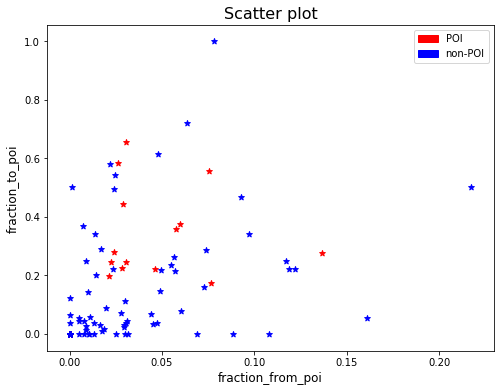

In [404]:
## scatter plot of "fraction_from_poi" & "fraction_to_poi"

plt.figure(figsize = (8,6))

for key in data_dict.keys():
    if data_dict[key]['poi'] == True:
        color = 'r'
        x = data_dict[key]['fraction_from_poi']
        y = data_dict[key]['fraction_to_poi']
        plt.scatter(x, y, marker = '*', c = color)
    elif data_dict[key]['poi'] == False:
        color = 'b'
        x = data_dict[key]['fraction_from_poi']
        y = data_dict[key]['fraction_to_poi']
        plt.scatter(x, y, marker = '*', c = color)
        
plt.xlabel('fraction_from_poi', fontsize = 12)
plt.ylabel('fraction_to_poi', fontsize = 12)
plt.title('Scatter plot', fontsize = 16)



red_patch = mpatches.Patch(color='red', label='POI')
blue_patch = mpatches.Patch(color='blue', label='non-POI')

plt.legend(handles=[red_patch, blue_patch])






From the above scatter plot, we can see that individuals having non-POI status has feature named 'fraction_to_poi' values less than 0.2 or less than 20%. Similary, feature 'fraction_from_poi' for non-POI's has values less than 0.02 approx. or less than 2%. This is definitely a strong pattern which would be helpful in our algorithms later on.

Let us add these 2 new features to our features_list.

In [405]:
if 'fraction_from_poi' not in features_list:
    features_list.append('fraction_from_poi')
if  'fraction_to_poi' not in features_list:
    features_list.append('fraction_to_poi')

In [406]:
pprint.pprint(features_list)

['poi',
 'salary',
 'to_messages',
 'deferral_payments',
 'total_payments',
 'exercised_stock_options',
 'bonus',
 'restricted_stock',
 'shared_receipt_with_poi',
 'restricted_stock_deferred',
 'total_stock_value',
 'expenses',
 'loan_advances',
 'from_messages',
 'other',
 'from_this_person_to_poi',
 'director_fees',
 'deferred_income',
 'long_term_incentive',
 'from_poi_to_this_person',
 'fraction_from_poi',
 'fraction_to_poi']


### Initial workout with Algorithms

Before working on the feature selection, feature scaling, let us use few algorithm to check how our data respond to the algorithms. 

###### GaussianNB

In [407]:
## Testing our dataset and features list with GaussianNB classifer

dataset = data_dict

## Creating and testing GaussianNB classifier
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()

test_classifier(clf, dataset, features_list)

GaussianNB(priors=None)
	Accuracy: 0.76980	Precision: 0.25448	Recall: 0.37650	F1: 0.30369	F2: 0.34355
	Total predictions: 15000	True positives:  753	False positives: 2206	False negatives: 1247	True negatives: 10794



###### SVM

In [408]:
## Testing our dataset and features list with SVM classifer
## Creating and testing SVM classifier

from sklearn.svm import SVC
clf = SVC()

test_classifier(clf, dataset, features_list)

Got a divide by zero when trying out: SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Precision or recall may be undefined due to a lack of true positive predicitons.


###### DecisionTree

In [409]:
## Testing our dataset and features list with DecisionTree classifer
## Creating and testing DecisionTree classifier

from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(random_state = 42)

test_classifier(clf, dataset, features_list)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best')
	Accuracy: 0.81827	Precision: 0.31094	Recall: 0.29850	F1: 0.30459	F2: 0.30091
	Total predictions: 15000	True positives:  597	False positives: 1323	False negatives: 1403	True negatives: 11677



Above are the various output values for the different algorithms when we have not selected and rescaled the features of the dataset. From the above 3 algorithms(GaussianNB, SVM & Decision Tree), SVM doesn't seem to work. So, we would proceed with Gaussian NB and DecisionTree alogorithms.  

### Evaluation Metrics

We can't improve what we can't measure. Similarly in creating a prediction model we need to use a kind of measurement to see if the model is good enough.
The two most important evaluation metrics are "Precision and Recall" and "F1". Precision and recall usually stick together as Precision is usually a trade-off against Recall.
We do the evaluation by cross-validating our prediction model with given testing dataset using a stratified shuffle split as coded in the tester.py.
Better F1 value means better model. In this project, we are tuning our classifier to achieve better than .3 precision and recall using our testing script in tester.py.

ACCURACY is proportion of all predictions that are correct. Accuracy is a measurment of how good a model is.


PRECISION is proportion of all positive predictions that are correct. Precision is a measure of how many positive predictions were actual positive observations. Precision is usually a trade-off against Recall. Precision is the ability of the classifier to not label as positive sample that is negative.

In context of our project " Precision would be the ratio of True predicted POI's and Total predicted POI's(which would also include False predicted POI)

RECALL is proportion of all real positive observations that are correct. Recall is the ability of the classifier to find all positive samples.

In context of our project " Recall would be the ratio of True predicted POI's and Sum of (True Predicted POI's and False Predicted non-POI's)


F1 Score is the harmonic mean of precision and recall. F1 score is an 'average' of both precision and recall. We use the harmonic mean because it is the appropriate way to average ratios. 


Essentially speaking, if a model has a precision score of x %, it tells us if this model predicts 100 POI's, there would be x people whom are actually POI's and the rest (100-x) are innocent. Ands if a model has recall score of y %, that means this model finds y% of all real POI's in prediction.

### Validation

The validation is a process of evaluating the peformance of the predictive model.

There are a number of strategies to validate a predictive model. One of them is to split the available data into training and testing data. Testing data gives the assessment of the performance of the classifier on an independent dataset and also help prevent overfitting of the classifier which mostly occurs when we use a small dataset with large number of features. In this scenario, whenever new testing data is thrown to the classifier to classify, classifier doesn't know to classify and as a result incorrect target are labelled. It doesn't generalizes well with the testing data. There is high error on testing data than on traininig data. It is a high variance type regime of Bias-Variance dilemna. A single split into a training & test set would not give a better estimate of error accuracy.


Using only the few features in the clasifier puts in the classic high biased type regime of the Bias-Variance dilemna where there are lot of features to describe the data and to find pattern but we only use few features to train the classifier. Therefore, we pay little attention to the data and predictive model is oversimplified and there is high error on training data.


Another approach is to perform a cross validation which is a process of splitting the data on k beans of equal size; run a learning experiment; repeat this operation k number of times and take the average test result from those k experiments. In this approach, we use all of the data for training and all of the data for testing.

And because of the small size of our dataset, with only 18 POI's, we would use stratified shuffle split cross validation where we randomly split the data into multiple trials while keeping the fraction of POIs in each trials relatively constant. Due to the nature of the dataset, accuracy is not a good measurement in this case because if we  predict all samples as non-POI's, the accuracy score will still be good and will yield that the model is a success. But we want that all POI's should be flagged as POI's. So Precision and Recall are the good measurement in this case.

### Parameter Tuning

Parameters tuning refers to the adjustment of the algorithm when training, in order to improve the fit on the testing data. Parameter can influence the outcome of the learning process, the more tuned the parameters, the more biased the algorithm will be to the training data. The strategy can be effective but it can also lead to more fragile models & overfit the training data but don't perform well in practice

Bias-variance tradeoff is one of the key dilema in machine learning. High bias algorithms has no capacity to learn, high variance algorithms react poorly in case they didn't saw such data before. Predictive model should be tuned to achieve compromise. The process of changing the parameteres of algorithms is algorithm tuning and it lets us find the golden mean and best result. If we don't tune the algorithm well, we don't get the best result that we could.
Algorithm might be tuned manually by iteratively changing the parameteres and tracking the results. Or GridSearchCV might be used which makes this automatically.

### Working out with GaussianNB

In [410]:
## Tetsing the GaussianNB classifier

clf = GaussianNB()
test_classifier(clf, dataset, features_list)

GaussianNB(priors=None)
	Accuracy: 0.76980	Precision: 0.25448	Recall: 0.37650	F1: 0.30369	F2: 0.34355
	Total predictions: 15000	True positives:  753	False positives: 2206	False negatives: 1247	True negatives: 10794



###### Rescaling the features

We have finanical and email features in our features_list and these two categories of features have different ranges of values. Financial features like 'salary', 'bonus' and 'exercised_stock_options' etc. have values in (thousands or hundreds of thousands) whereas email features like  'to_messages', 'from_this_person_to_poi' etc. have values in (hundreds or thousands), therefore these two category are inbalanced and finanical features would end up dominating the email features. In order, that these two category weigh equals in the predictive model, we have to rescale the featues so that these category features are balanced out. These rescaled features would point out to the same earlier values but now in different same scale. This is to ensure, for example, a relatively high number of messages compared to other messages are not valued less than relatively low amount of salary compared to all salaries.

In [411]:
###### Rescaling the features and using Pipeline

from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

estimators = [('scaler', MinMaxScaler()), ('clf', GaussianNB())]
pipe_clf = Pipeline(estimators)

## Testing the GaussianNB classifier with the rescaled features

test_classifier(pipe_clf, dataset, features_list)

Pipeline(steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('clf', GaussianNB(priors=None))])
	Accuracy: 0.47660	Precision: 0.17834	Recall: 0.81100	F1: 0.29238	F2: 0.47441
	Total predictions: 15000	True positives: 1622	False positives: 7473	False negatives:  378	True negatives: 5527



Rescaling of the features with GaussianNB didn't produced better results as when using the non-scaled features. The accuracy has dropped from 0.76980 to 0.47660. Let us just use, the original features for GaussianNB.

###### Selecting top 10 features

In [412]:
## Selecting Top 10 features 

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.cross_validation import StratifiedShuffleSplit

data = featureFormat(dataset, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)

cv = StratifiedShuffleSplit(labels, random_state = 42)

for train_idx, test_idx in cv: 
        features_train = []
        features_test  = []
        labels_train   = []
        labels_test    = []
        for ii in train_idx:
            features_train.append( features[ii] )
            labels_train.append( labels[ii] )
        for jj in test_idx:
            features_test.append( features[jj] )
            labels_test.append( labels[jj] )
    
selector = SelectKBest(f_classif, k = 10)
selector.fit(features_train, labels_train)

from operator import itemgetter
features_score = []
for i,score in enumerate(selector.scores_):
        features_score.append((features_list[i+1], score))
       

    
print " Top 10 best features are:\n"    
pprint.pprint(sorted(features_score, key = itemgetter(1), reverse = True)[0:10])
    


    
                              

 Top 10 best features are:

[('bonus', 23.023193034632005),
 ('salary', 20.839153801164169),
 ('fraction_to_poi', 18.680300615445152),
 ('deferred_income', 12.629759158698027),
 ('total_stock_value', 12.058903589560817),
 ('shared_receipt_with_poi', 11.719093382602846),
 ('exercised_stock_options', 11.196536151953884),
 ('long_term_incentive', 10.753512449862587),
 ('total_payments', 9.6684821961228113),
 ('restricted_stock', 7.3760180943963727)]


From the above, it appears that 'bonus', 'salary' and our newly created feature 'fraction_to_poi' are three top most best features. So, 'fraction_to_poi' would definitely have an effect in the performance of the predictive model.

###### Using Top 12 features

In [413]:
## Using Top 12 features with pipeline

from sklearn.feature_selection import SelectKBest

estimators = [('selector', SelectKBest(k = 12)), ('clf', GaussianNB())]
pipe_clf = Pipeline(estimators)

# pipe_clf

test_classifier(pipe_clf, dataset, features_list)


Pipeline(steps=[('selector', SelectKBest(k=12, score_func=<function f_classif at 0x000000000C27B198>)), ('clf', GaussianNB(priors=None))])
	Accuracy: 0.85507	Precision: 0.44161	Recall: 0.32900	F1: 0.37708	F2: 0.34668
	Total predictions: 15000	True positives:  658	False positives:  832	False negatives: 1342	True negatives: 12168



Selecting the top 12 features and using in the classifier has definitely increased the accuracy from 0.76980 to 0.85507.
Also, Precision, Recall and F1 values have better values after using best 12 features and are above 0.30.

###### Using PCA 

In [414]:
## using PCA with the classifier to reduce dimensions

from sklearn.decomposition import PCA

estimators = [('selector', SelectKBest(f_classif, k = 12)), 
              ('reduce_dim', PCA(random_state=42)),
              ('clf', GaussianNB())]
pipe_clf = Pipeline(estimators)

test_classifier(pipe_clf, dataset, features_list)

Pipeline(steps=[('selector', SelectKBest(k=12, score_func=<function f_classif at 0x000000000C27B198>)), ('reduce_dim', PCA(copy=True, iterated_power='auto', n_components=None, random_state=42,
  svd_solver='auto', tol=0.0, whiten=False)), ('clf', GaussianNB(priors=None))])
	Accuracy: 0.86187	Precision: 0.47418	Recall: 0.33050	F1: 0.38951	F2: 0.35182
	Total predictions: 15000	True positives:  661	False positives:  733	False negatives: 1339	True negatives: 12267



Using PCA in the pipeline has increased accuracy slightly from 0.85507 to 0.86187. Also, the Precision and Recall has increased slighlty. F1 score has also increased slightly. These are the best scores we have got till now, for GaussianNB. we would use next, the GridSearchCV for for finding the best params.

###### Using GridSearchCV

In [415]:
## Using GridSearchCV, fitting the training data and finding the best params

from sklearn.model_selection import GridSearchCV

estimators = [('selector', SelectKBest(f_classif)), 
              ('reduce_dim', PCA(random_state=42)),
              ('clf', GaussianNB())]

pipe_clf = Pipeline(estimators)

params = dict(selector__k=[8,10,12],
              reduce_dim__n_components=[None,1,2,3,4,5,6])

grid_search = GridSearchCV(pipe_clf, param_grid=params)

grid_search.fit(features_train, labels_train)

print 'The best params after using the GridSearchCV are:\n'
print grid_search.best_params_

The best params after using the GridSearchCV are:

{'selector__k': 10, 'reduce_dim__n_components': 2}


###### Testing the GaussianNB classifier with best params 

In [416]:
## Tetsing the GaussianNB classifier with the best params

estimators = [('selector', SelectKBest(f_classif, k = 10)), 
              ('reduce_dim', PCA(n_components = 2, random_state=42)),
              ('clf', GaussianNB())]
pipe_clf = Pipeline(estimators)


test_classifier(pipe_clf, dataset, features_list)

Pipeline(steps=[('selector', SelectKBest(k=10, score_func=<function f_classif at 0x000000000C27B198>)), ('reduce_dim', PCA(copy=True, iterated_power='auto', n_components=2, random_state=42,
  svd_solver='auto', tol=0.0, whiten=False)), ('clf', GaussianNB(priors=None))])
	Accuracy: 0.87333	Precision: 0.55230	Recall: 0.26400	F1: 0.35724	F2: 0.29477
	Total predictions: 15000	True positives:  528	False positives:  428	False negatives: 1472	True negatives: 12572



Well, this time, we got the accuracy as 0.87327 which is maximum till yet although we have also increased Precision but this has lead to loss in Recall.

###### Final settings in order to have best accuracy with precision and recall more than 0.30 

Since, for this project, our aim is to tune our classifier to achieve better than .3 precision and recall using our testing script, we would stay with selecting best features i.e. using SelectKBest with K=12 (k = 8 and 10 has lead to either precision or either recall less than 0.30) and using PCA with n_components = 6.

In [417]:
estimators = [('selector', SelectKBest(f_classif, k = 12)), 
              ('reduce_dim', PCA(n_components = 6,random_state=42)),
              ('clf', GaussianNB())]
pipe_clf = Pipeline(estimators)

test_classifier(pipe_clf, dataset, features_list)

Pipeline(steps=[('selector', SelectKBest(k=12, score_func=<function f_classif at 0x000000000C27B198>)), ('reduce_dim', PCA(copy=True, iterated_power='auto', n_components=6, random_state=42,
  svd_solver='auto', tol=0.0, whiten=False)), ('clf', GaussianNB(priors=None))])
	Accuracy: 0.85660	Precision: 0.44797	Recall: 0.32500	F1: 0.37670	F2: 0.34388
	Total predictions: 15000	True positives:  650	False positives:  801	False negatives: 1350	True negatives: 12199



With the above parms, we are getting slightly lower accuracy of 0.85660 as when using GridSearchCV which was 0.87333.
But this accuracy is quite good as when compared to only using the classifier without any feature selction and PCA which was 0.76980.
Also, the Precision is 0.44797 and Recall is 0.32500 which are better than our aim of 0.30.

### Working out with DecisionTree

In [418]:
## Testing the DecisionTree classifier

clf = DecisionTreeClassifier(random_state = 42)

test_classifier(clf, dataset, features_list)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best')
	Accuracy: 0.81827	Precision: 0.31094	Recall: 0.29850	F1: 0.30459	F2: 0.30091
	Total predictions: 15000	True positives:  597	False positives: 1323	False negatives: 1403	True negatives: 11677



###### Rescaling the features

In [419]:
## Rescaling the features and using Pipeline

estimators = [('scaler', MinMaxScaler()), ('clf', DecisionTreeClassifier(random_state = 42))]                                           

pipe_clf = Pipeline(estimators)

## Testing the DecisionTree classifier with the rescaled features

test_classifier(pipe_clf, dataset, features_list)

Pipeline(steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('clf', DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'))])
	Accuracy: 0.81827	Precision: 0.31094	Recall: 0.29850	F1: 0.30459	F2: 0.30091
	Total predictions: 15000	True positives:  597	False positives: 1323	False negatives: 1403	True negatives: 11677



Well, the metrics values after using rescaled features are still the same as when non-scaled features were used. It looks like rescaling didn't had any effect on DecisionTreee classifier. So, proceeding with original features only while working out with DecisionTree Classifier.  

###### Feature Importance

In [420]:
## Feature Importance of features used in DecisionTree classifier

clf = DecisionTreeClassifier(random_state = 42)
clf.fit(features_train, labels_train)
clf.feature_importances_

features_importance = []
for i,imp in enumerate(clf.feature_importances_):
        features_importance.append((features_list[i+1], imp))
       

    
print "Features importance are:\n"    
pprint.pprint(sorted(features_importance, key = itemgetter(1), reverse = True))

Features importance are:

[('shared_receipt_with_poi', 0.24148406753495255),
 ('fraction_to_poi', 0.23946905254619766),
 ('expenses', 0.16120421418768638),
 ('other', 0.14014867095789302),
 ('deferred_income', 0.069049083268845679),
 ('salary', 0.053512168141592924),
 ('deferral_payments', 0.047566371681415927),
 ('restricted_stock', 0.047566371681415927),
 ('to_messages', 0.0),
 ('total_payments', 0.0),
 ('exercised_stock_options', 0.0),
 ('bonus', 0.0),
 ('restricted_stock_deferred', 0.0),
 ('total_stock_value', 0.0),
 ('loan_advances', 0.0),
 ('from_messages', 0.0),
 ('from_this_person_to_poi', 0.0),
 ('director_fees', 0.0),
 ('long_term_incentive', 0.0),
 ('from_poi_to_this_person', 0.0),
 ('fraction_from_poi', 0.0)]


'shared_receipt_with_poi', 'fraction_to_poi' and 'expenses' are the features with 3 top most importance. Our newly created 'fraction_to_poi' is again in the top 3 list and would have a strong effect on the performance of the predictive model.

###### Making  new list features_imp_list which contains only features having importance greater than 0 and feature 'poi'

In [421]:
## Making  new list features_imp_list which contains only features having importance greater than 0 and feature 'poi'

features_imp_list =[]
for feature,imp in sorted(features_importance, key = itemgetter(1), reverse = True):
    if imp > 0.0:
        features_imp_list.append(feature)

           
features_imp_list.insert(0, 'poi')
features_imp_list


['poi',
 'shared_receipt_with_poi',
 'fraction_to_poi',
 'expenses',
 'other',
 'deferred_income',
 'salary',
 'deferral_payments',
 'restricted_stock']

###### Using only important fetaures

In [422]:
## Testing the DecisionTree classifier with only important features

clf = DecisionTreeClassifier(random_state = 42)
test_classifier(clf, dataset, features_imp_list)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best')
	Accuracy: 0.83114	Precision: 0.41008	Recall: 0.41500	F1: 0.41252	F2: 0.41401
	Total predictions: 14000	True positives:  830	False positives: 1194	False negatives: 1170	True negatives: 10806



By only using important features in the features_imp_list, our Accuracy, Precison and Recall has increased. Lets work out further in increasing these metrics more. 

###### Using PCA

In [423]:
## using PCA with the claasifier to reduce dimensions

estimators = [('reduce_dim', PCA(random_state=42)),
              ('clf', DecisionTreeClassifier(random_state = 42))]
               
pipe_clf = Pipeline(estimators)

test_classifier(pipe_clf, dataset, features_imp_list)

Pipeline(steps=[('reduce_dim', PCA(copy=True, iterated_power='auto', n_components=None, random_state=42,
  svd_solver='auto', tol=0.0, whiten=False)), ('clf', DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'))])
	Accuracy: 0.77979	Precision: 0.22016	Recall: 0.21300	F1: 0.21652	F2: 0.21439
	Total predictions: 14000	True positives:  426	False positives: 1509	False negatives: 1574	True negatives: 10491



PCA has not helped in getting the better results. So, we would move forward without PCA.

###### Using GridSearchCV

In [424]:
## Using GridSearchCV, fitting the training data and finding the best params

params = {'criterion':('gini','entropy'),
          'min_samples_split':(2,4,6,8,10,12),
          'min_samples_leaf':(2,4,6,8),
          'max_depth':(3,4,5,6)
             }

clf = DecisionTreeClassifier(random_state = 42)

grid_search = GridSearchCV(clf, param_grid=params)

grid_search.fit(features_train, labels_train)

print 'The best params after using the GridSearchCV are:\n'
print grid_search.best_params_

The best params after using the GridSearchCV are:

{'min_samples_split': 2, 'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 8}


###### Testing the DecisionTree classifier with best params 

In [425]:
## Testing the DecisionTree classifier with the best params and using features_imp_list which contains features
## with importance greater than 0 and 'poi'

clf = DecisionTreeClassifier(criterion = 'entropy',
                             max_depth = 3,
                             min_samples_leaf = 8,
                             min_samples_split = 2,
                             random_state = 42)


test_classifier(clf, dataset, features_imp_list)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=8,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best')
	Accuracy: 0.88414	Precision: 0.62353	Recall: 0.47700	F1: 0.54051	F2: 0.50052
	Total predictions: 14000	True positives:  954	False positives:  576	False negatives: 1046	True negatives: 11424



After using the best params with the DecisionTree classifier, we have got the accuracy increased from 0.81827 to 0.88414. Also, Precision and Recall has drastically increased with good margins. Precision has a value of 0.62353 and Recall has a value of 0.47700. Both Precision and Recall are above our aim of 0.30

### Working out with Adaboost

We would use the Adaboost classifier with base estimator as DecisionTree classifier with best params to see if we can further improve the predictive model.

###### Using GridSearchCV

In [426]:
## Using GridSearchCV, fitting the training data and finding the best params

from sklearn.ensemble import AdaBoostClassifier

params = {'n_estimators':(10,20,30,40,50,60,70,80),
          'learning_rate':(0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8)}

clf = AdaBoostClassifier(random_state = 42,
                         base_estimator = DecisionTreeClassifier(criterion = 'entropy',
                                                                 max_depth = 3,
                                                                 min_samples_leaf = 8,
                                                                 min_samples_split = 2,
                                                                 random_state = 42))

grid_search = GridSearchCV(clf, param_grid=params)

grid_search.fit(features_train, labels_train)

print 'The best params after using the GridSearchCV are:\n'
print grid_search.best_params_

The best params after using the GridSearchCV are:

{'n_estimators': 10, 'learning_rate': 0.1}


###### Testing the Adaboost classifier with best params

In [427]:
## Testing the Adaboost classifier with best params keeping base estimators as DecisionTree classifier with best params
## and features list as features_imp_list

clf = AdaBoostClassifier(random_state = 42,
                         n_estimators = 10,
                         learning_rate = 1,
                         base_estimator = DecisionTreeClassifier(criterion = 'entropy',
                                                                 max_depth = 3,
                                                                 min_samples_leaf = 8,
                                                                 min_samples_split = 2,
                                                                 random_state = 42))

test_classifier(clf, dataset, features_imp_list)

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=8,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1, n_estimators=10, random_state=42)
	Accuracy: 0.84114	Precision: 0.41753	Recall: 0.28350	F1: 0.33770	F2: 0.30295
	Total predictions: 14000	True positives:  567	False positives:  791	False negatives: 1433	True negatives: 11209



Looks like this boosting with AdaBoost worsen our model. Accuracy has dropped from 0.88414 to 0.84114. Also, the Precision and Recall has dropped considerably such that Recall is now under our aim of 0.30.

### Comparison of different algorithms

In [432]:
## Comparison of different algorithms

pd.DataFrame([[0.85660, 0.44797, 0.32500, 0.37670],
             [0.88414, 0.62353, 0.47700, 0.54051],
             [0.84114, 0.41753, 0.28350, 0.33770]],
             columns = ['Accuracy','Precision', 'Recall', 'F1'], 
             index = ['Gaussian Naive Bayes', 'Decision Tree Classifier', 'Adaboost'])


,Accuracy,Precision,Recall,F1
Gaussian Naive Bayes,0.85660,0.44797,0.3250,0.37670
Decision Tree Classifier,0.88414,0.62353,0.4770,0.54051
Adaboost,0.84114,0.41753,0.2835,0.33770


From the above dataframe, we can clearly see that DecisionTree classifier has the highest metrics in Accuracy, Precision, Recall and F1. Therefore, we will keep our previous DecisionTree-based prediction model.

### Conclusion

#### DecisionTree classifier is our final predictive model which when tested with best params and important features yield accuracy of 0.88414 with Precision & Recall of 0.62353 & 0.47700 respectively which is above our aim of achieving better than .3 precision and recall.

In the end, I managed to get the prediction model to have 88% accuracy in predicting whether a person is suspicious enough to be a Person of Interest based on their insider pay and email statistics. But accuracy is not the most important metrics here, and can even be misleading.

Accuracy of 88% means "out of all our predictions, We can be sure 88% are correct", but then since the number of POI's are much less than non-POI's, we can just predict all as non-POI's and still get very good accuracy.

The more important metrics here are precision and recall, that is:

Precision: How exact my prediction is i.e. since we got 62%, then out of 100 people the model predicted as POI, we can be sure that 62 of them are indeed POIs.
Recall: How complete my prediction is i.e. with score of 47%, given total 100 POIs in a dataset, this model can find 47 of them.

In [429]:
## Testing the DecisionTree classifier with the best params and using features_imp_list which contains features
## with importance greater than 0 and feature 'poi'

clf = DecisionTreeClassifier(criterion = 'entropy',
                             max_depth = 3,
                             min_samples_leaf = 8,
                             min_samples_split = 2,
                             random_state = 42)


test_classifier(clf, dataset, features_imp_list)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=8,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best')
	Accuracy: 0.88414	Precision: 0.62353	Recall: 0.47700	F1: 0.54051	F2: 0.50052
	Total predictions: 14000	True positives:  954	False positives:  576	False negatives: 1046	True negatives: 11424



###### Dumping classifier, dataset, and features_list

In the end, taking a dump of classifier, dataset and features_list to pickle(.pkl) files which can then be used by tester.py file to test the classifier using pickle files.

In [430]:
## clf is DecisionTree classifier with best params
## dataset is the data_dict in which data has been corrected and outliers removed
## features_imp_list is the list of important features.

dump_classifier_and_data(clf, dataset, features_imp_list)

print "Classifier, dataset and features list has been dumped\n"
print "Three pickle files (my_dataset.pkl, my_classifier.pkl, my_feature_list.pkl) has been generated."
print "Please run tester.py to test these pickle files"


Classifier, dataset and features list has been dumped

Three pickle files (my_dataset.pkl, my_classifier.pkl, my_feature_list.pkl) has been generated.
Please run tester.py to test these pickle files
